In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", "..", ".."))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import pickle, lzma

import open_cp.network
import open_cp.geometry
import open_cp.network_hotspot
import open_cp.logger
import open_cp.prohotspot
import open_cp.sources.chicago
import open_cp.evaluation
import descartes
open_cp.logger.log_to_true_stdout()

In [3]:
import pickle, lzma
with lzma.open("input_old.pic.xz", "rb") as f:
    timed_points = pickle.load(f)
print(timed_points.time_range)
with open("input.graph", "rb") as f:
    graph = open_cp.network.PlanarGraph.from_bytes(f.read())

(numpy.datetime64('2001-01-01T11:30:00.000'), numpy.datetime64('2014-05-24T18:00:00.000'))


# Network

We use the "fast predictor"...

From cross-validation, we use 500m and 55 days.

In [4]:
trainer = open_cp.network_hotspot.Trainer()
trainer.graph = graph
trainer.maximum_edge_length = 20
trainer.data = timed_points
predictor = trainer.compile()

In [5]:
tstart = np.datetime64("2013-01-01")
tend = np.datetime64("2013-01-01") + np.timedelta64(180, "D")

def score(predictor):
    risks = dict()
    for day in range(60):
        start = tend + np.timedelta64(1, "D") * day
        end = tend + np.timedelta64(1, "D") * (day + 1)
        result = predictor.predict(cutoff_time=tstart, predict_time=start)
        risks[start] = result.risks
    return risks

In [6]:
pred = open_cp.network_hotspot.ApproxPredictorCaching(predictor)
pred.kernel = open_cp.network_hotspot.TriangleKernel(500)
pred.time_kernel = open_cp.network_hotspot.ExponentialTimeKernel(55)

In [7]:
risks = score(pred)

In [8]:
with lzma.open("network_risks.pic.xz", "wb") as f:
    pickle.dump(risks, f)

# Grid prediction

We form a grid prediction, and then constrain it to a network.

In [6]:
data_path = os.path.join("/media", "disk", "Data")
#data_path = os.path.join("..", "..", "..", "..", "..", "..", "Data")
open_cp.sources.chicago.set_data_directory(data_path)
south_side = open_cp.sources.chicago.get_side("South")

In [7]:
grid = open_cp.data.Grid(xsize=150, ysize=150, xoffset=0, yoffset=0)
grid = open_cp.geometry.mask_grid_by_intersection(south_side, grid)

In [8]:
class OurWeight():
    def __init__(self):
        self.time_bandwidth = 100
        self.space_bandwidth = 10
    
    def __call__(self, dt, dd):
        kt = np.exp(-dt / self.time_bandwidth) / self.time_bandwidth
        dd = np.atleast_1d(np.asarray(dd))
        #ks = (self.space_bandwidth - dd) / (self.space_bandwidth * self.space_bandwidth * dd * np.pi)
        ks = ((self.space_bandwidth - dd) / (self.space_bandwidth * self.space_bandwidth
                                             * np.pi * self.space_bandwidth) * 3)
        mask = dd > self.space_bandwidth
        ks[mask] = 0
        return kt * ks

In [9]:
def score(predictor):
    grids = dict()
    for day in range(60):
        start = tend + np.timedelta64(1, "D") * day
        end = tend + np.timedelta64(1, "D") * (day + 1)
        prediction = predictor.predict(tend, tend)
        prediction.samples = 5
        grid_pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(prediction, grid)
        grid_pred.mask_with(grid)
        grids[start] = grid_pred.renormalise()
    return grids

In [10]:
grid_predictor = open_cp.prohotspot.ProspectiveHotSpotContinuous(grid_size=150, time_unit=np.timedelta64(1, "D"))
grid_predictor.data = timed_points[timed_points.timestamps >= np.datetime64("2013-01-01")]
grid_predictor.weight = OurWeight()
grid_predictor.weight.space_bandwidth = 500 / grid_predictor.grid
grid_predictor.weight.time_bandwidth = 60

In [11]:
grids = score(grid_predictor)

### Convert to network risks and visualise

In [12]:
key = list(grids)[0]
prediction = grids[key]
_,_,risks = open_cp.evaluation.grid_risk_to_graph(prediction, predictor.graph)

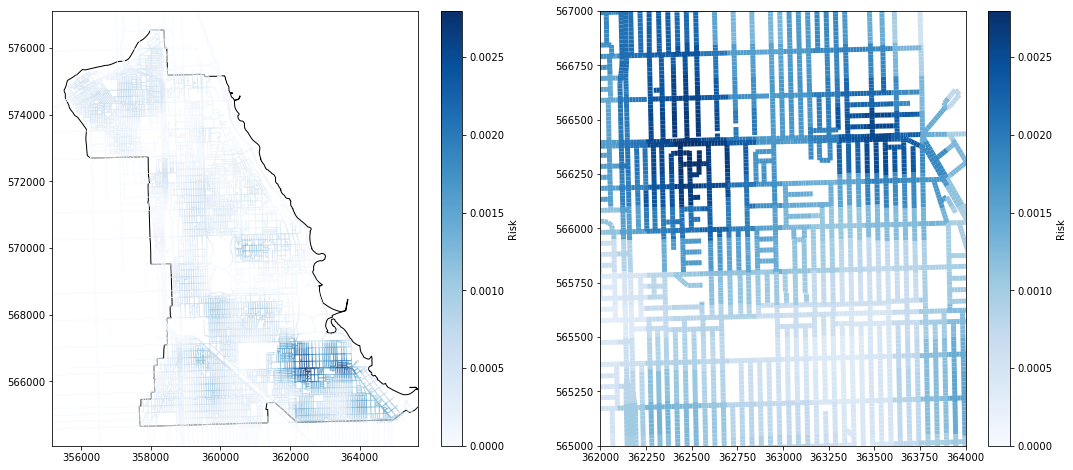

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax, lw in zip(axes, [1,5]):
    ax.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
    lc = matplotlib.collections.LineCollection(predictor.graph.as_lines(), linewidth=lw, cmap="Blues")
    lc.set_array(risks)
    ax.add_collection(lc)

    cbar = fig.colorbar(lc, orientation="vertical", ax=ax)
    cbar.set_label("Risk")

xmin, ymin, xmax, ymax = *timed_points.bounding_box.min, *timed_points.bounding_box.max
xd, yd = xmax - xmin, ymax - ymin
axes[0].set(xlim=(xmin-xd/20, xmax+xd/20), ylim=(ymin-yd/20, ymax+yd/20))
axes[1].set(xlim=[362000, 364000], ylim=[565000, 567000])
None

In [14]:
coverage_mask = open_cp.evaluation.network_coverage(predictor.graph, risks, 0.1)

In [15]:
# Check we get about 10%
sum(predictor.graph.lengths), sum(predictor.graph.lengths[coverage_mask]), sum(predictor.graph.lengths[coverage_mask]) / sum(predictor.graph.lengths) * 100

(1443127.2144894809, 144301.10911164118, 9.9991953351589302)

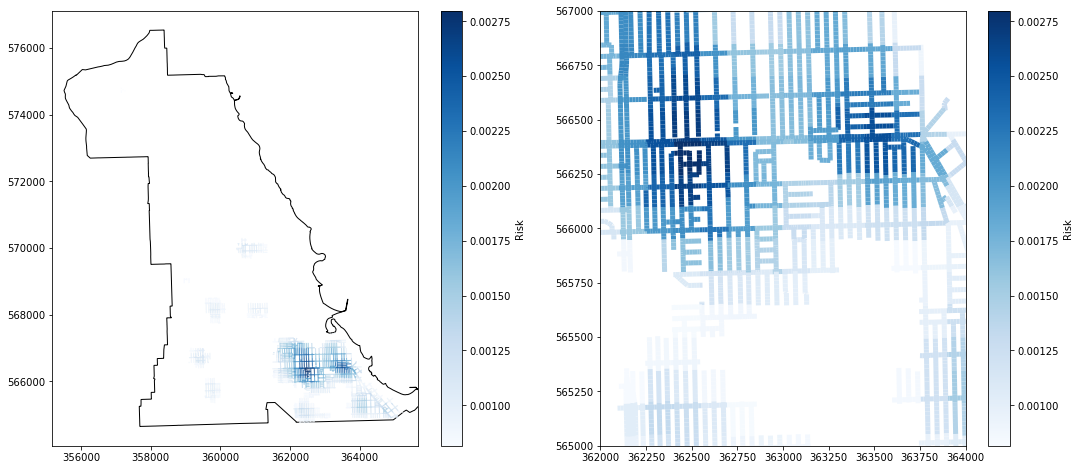

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax, lw in zip(axes, [1,5]):
    ax.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
    lines = np.asarray(predictor.graph.as_lines())
    lc = matplotlib.collections.LineCollection(lines[coverage_mask], linewidth=lw, cmap="Blues")
    lc.set_array(risks[coverage_mask])
    ax.add_collection(lc)

    cbar = fig.colorbar(lc, orientation="vertical", ax=ax)
    cbar.set_label("Risk")

xmin, ymin, xmax, ymax = *timed_points.bounding_box.min, *timed_points.bounding_box.max
xd, yd = xmax - xmin, ymax - ymin
axes[0].set(xlim=(xmin-xd/20, xmax+xd/20), ylim=(ymin-yd/20, ymax+yd/20))
axes[1].set(xlim=[362000, 364000], ylim=[565000, 567000])
None

In [17]:
with lzma.open("network_risks.pic.xz", "rb") as f:
    risks = pickle.load(f)
risks = risks[key]

In [18]:
coverage_mask = open_cp.evaluation.network_coverage(predictor.graph, risks, 0.1)

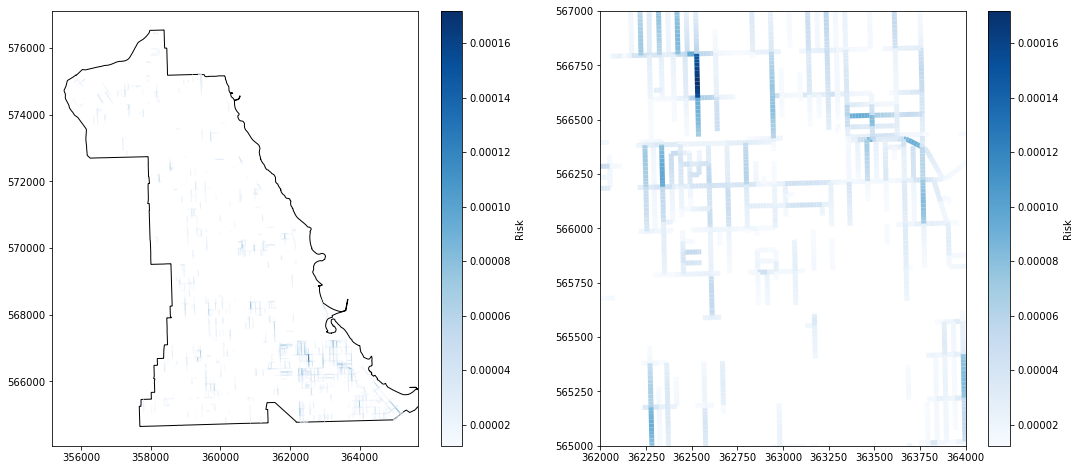

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax, lw in zip(axes, [1,5]):
    ax.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
    lines = np.asarray(predictor.graph.as_lines())
    lc = matplotlib.collections.LineCollection(lines[coverage_mask], linewidth=lw, cmap="Blues")
    lc.set_array(risks[coverage_mask])
    ax.add_collection(lc)

    cbar = fig.colorbar(lc, orientation="vertical", ax=ax)
    cbar.set_label("Risk")

xmin, ymin, xmax, ymax = *timed_points.bounding_box.min, *timed_points.bounding_box.max
xd, yd = xmax - xmin, ymax - ymin
axes[0].set(xlim=(xmin-xd/20, xmax+xd/20), ylim=(ymin-yd/20, ymax+yd/20))
axes[1].set(xlim=[362000, 364000], ylim=[565000, 567000])
None

# Hit-rate scores

In [20]:
coverages = list(range(1,31))

In [21]:
def grid_hit_rates(grids, coverages):
    out = dict()
    for day in range(60):
        start = tend + np.timedelta64(1, "D") * day
        end = tend + np.timedelta64(1, "D") * (day + 1)
        ntp = predictor.network_timed_points
        mask = (ntp.timestamps > start) & (ntp.timestamps <= end)
        ntp = ntp[mask]
        grid_prediction = grids[start]
        _,_,risks = open_cp.evaluation.grid_risk_to_graph(grid_prediction, predictor.graph)
        out[start] = open_cp.evaluation.network_hit_rates_from_coverage(predictor.graph, risks, ntp, coverages)
    return out

In [22]:
grid_hr = grid_hit_rates(grids, coverages)

In [23]:
with lzma.open("network_risks.pic.xz", "rb") as f:
    risks = pickle.load(f)

In [24]:
def network_hit_rates(risks, coverages):
    out = dict()
    for day in range(60):
        start = tend + np.timedelta64(1, "D") * day
        end = tend + np.timedelta64(1, "D") * (day + 1)
        ntp = predictor.network_timed_points
        mask = (ntp.timestamps > start) & (ntp.timestamps <= end)
        out[start] = open_cp.evaluation.network_hit_rates_from_coverage(
                        predictor.graph, risks[start], ntp[mask], coverages)
    return out

In [25]:
network_hr = network_hit_rates(risks, coverages)

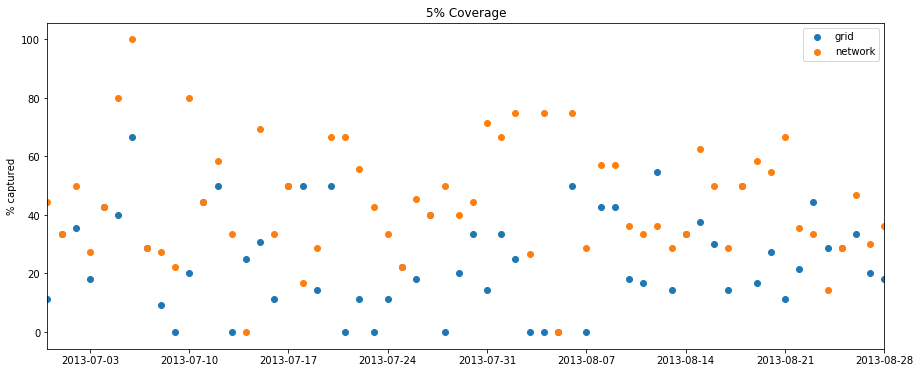

In [26]:
fig, ax = plt.subplots(figsize=(15,6))

starts = list(grid_hr)
starts.sort()
ax.scatter(starts, [grid_hr[s][5] for s in starts])
ax.scatter(starts, [network_hr[s][5] for s in starts])
ax.set(xlim=[min(starts), max(starts)])
ax.set(title="5% Coverage", ylabel="% captured")
ax.legend(["grid", "network"])
None

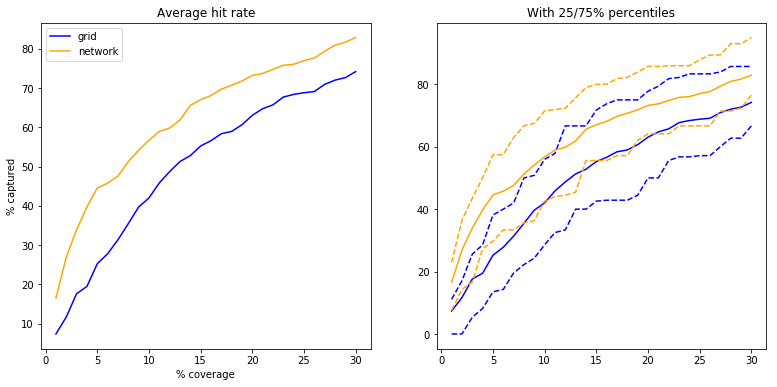

In [27]:
cov = coverages
grid_avg = [ np.mean([x[c] for x in grid_hr.values()]) for c in cov ]
network_avg = [ np.mean([x[c] for x in network_hr.values()]) for c in cov ]

fig, axes = plt.subplots(ncols=2, figsize=(13,6))

ax = axes[0]
ax.plot(cov, grid_avg, color="blue")
ax.plot(cov, network_avg, color="orange")
ax.set(title="Average hit rate", ylabel="% captured", xlabel="% coverage")
ax.legend(["grid", "network"])

ax = axes[1]
ax.plot(cov, grid_avg, color="blue")
y = [ np.percentile([x[c] for x in grid_hr.values()], 25) for c in cov ]
ax.plot(cov, y, color="blue", linestyle="--")
y = [ np.percentile([x[c] for x in grid_hr.values()], 75) for c in cov ]
ax.plot(cov, y, color="blue", linestyle="--")

ax.plot(cov, network_avg, color="orange")
y = [ np.percentile([x[c] for x in network_hr.values()], 25) for c in cov ]
ax.plot(cov, y, color="orange", linestyle="--")
y = [ np.percentile([x[c] for x in network_hr.values()], 75) for c in cov ]
ax.plot(cov, y, color="orange", linestyle="--")
ax.set(title="With 25/75% percentiles")

None

# Conclusion

This reproduces the findings of Rosser et al. showing that the network hotspot techniques captures more crime, per percentage coverage, than the grid based hotspot.

However, it is worth noting that the hotspot maps so produced seem _qualitatively_ different (see the plots above).  The network "hotspots" are much more spatially variable, and would be harder to patrol.

## Re-run with different grid size

The plots below come from re-running the notebook using a grid size of 50m instead of 150m.  Not a huge amount of difference.

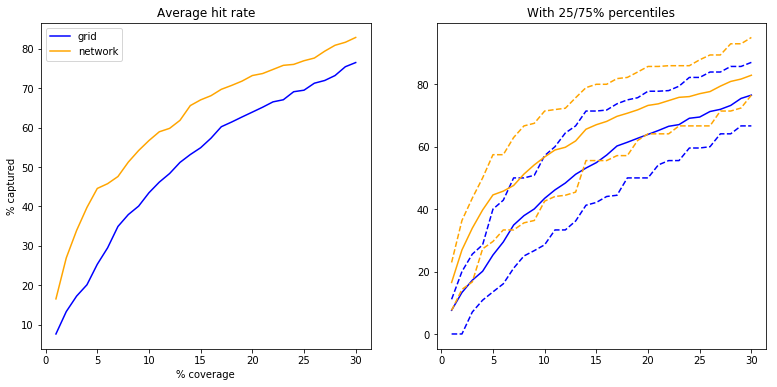

In [34]:
cov = coverages
grid_avg = [ np.mean([x[c] for x in grid_hr.values()]) for c in cov ]
network_avg = [ np.mean([x[c] for x in network_hr.values()]) for c in cov ]

fig, axes = plt.subplots(ncols=2, figsize=(13,6))

ax = axes[0]
ax.plot(cov, grid_avg, color="blue")
ax.plot(cov, network_avg, color="orange")
ax.set(title="Average hit rate", ylabel="% captured", xlabel="% coverage")
ax.legend(["grid", "network"])

ax = axes[1]
ax.plot(cov, grid_avg, color="blue")
y = [ np.percentile([x[c] for x in grid_hr.values()], 25) for c in cov ]
ax.plot(cov, y, color="blue", linestyle="--")
y = [ np.percentile([x[c] for x in grid_hr.values()], 75) for c in cov ]
ax.plot(cov, y, color="blue", linestyle="--")

ax.plot(cov, network_avg, color="orange")
y = [ np.percentile([x[c] for x in network_hr.values()], 25) for c in cov ]
ax.plot(cov, y, color="orange", linestyle="--")
y = [ np.percentile([x[c] for x in network_hr.values()], 75) for c in cov ]
ax.plot(cov, y, color="orange", linestyle="--")
ax.set(title="With 25/75% percentiles")

None